# Práctica 1: Análsis de sentimientos - Aitana Villaplana Moreno
En esta práctica sen va a desarrollar diferentes sistemas para realizar una tarea de análisis de sentimientos, se desarrollarán sistemas clásicos de ML, y Redes Neuronales, además de trabajar con los distintos tipo de parámetros de los mismos.


##1. Importación de librerías, carga y visualización de los datos
En primer lugar se importarán las librerías necesarias para el desarrollo de la práctica. En segundo lugar se cargarán los dos ficheros del conjunto de datos, subidos la carpeta del drive, el conjunto de entrenamiento (training) y el conjunto de validación (test)

In [1]:
# Procesado de datos
import pandas as pd
import numpy as np
from numpy import asarray
#np.set_printoptions(threshold=np.inf)
from nltk.tokenize import WhitespaceTokenizer
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Representación de datos
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec, FastText

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Clasificación
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

# Utiles
import pickle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# Importamos capas densas, capas de embeddings y capas para el aplanado de dimensiones
from keras.layers import Dense, Embedding, Flatten

# Importamos las herramientas para generar el modelo y trabajar con las entradas
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# Métricas de evaluación
from keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score

# Herramienta para la gestión de las etiquetas de salida
from keras.utils.np_utils import to_categorical

# Procesado del texto
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Modelo para utilizar en el grid search
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
# Enlazamos el notebook en Colab con nuestro almacenamiento en Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Se carga el dataset en un objeto de la clase pandas
training_set = pd.read_csv("/content/drive/My Drive/train_reviews.csv", quotechar='"', header=0, sep=",")
test_set = pd.read_csv("/content/drive/My Drive/test_reviews.csv", quotechar='"', header=0, sep=",")

# Visualizamos las 10 primeras filas del conjunto de entrenamiento, se puede ver que consta de 3 columnas, el id, la reseña y el label del sentimiento (positivo / negativo)
training_set.head(10)

,id,review,sentiment
0,17527,People tried to make me believe that the premi...,negative
1,24155,I have been wanting to see cut since the day i...,positive
2,21972,This movie is terrible. The suspense is spent ...,negative
3,4565,I hope she can keep acting and directing. She'...,positive
4,22098,I fell in love with this silent action drama. ...,positive
5,5138,Shame Shame Shame on UA/DW for what you do! <b...,negative
6,16932,It's not very often a movie can literally make...,positive
7,13181,I was very interested to see this movie when i...,positive
8,3299,It might not be the best movie of 2006 but it ...,positive
9,18982,I went to see the Omega Code with a group of o...,negative


In [ ]:
# Visualizamos las 10 primeras filas del conjunto de test
test_set.head(10)

,id,review,sentiment
0,6666,Movies about dinosaurs can be entertaining. So...,negative
1,23267,If it's action and adventure you want in a mov...,positive
2,2897,Barbra Streisand is a tour de force in this Ho...,positive
3,23177,I borrowed this movie despite its extremely lo...,positive
4,14171,"""Baby Face"" is a precode melodrama starring a ...",positive
5,17212,Pokemon 3 is little more than three or four ep...,negative
6,22006,"Well, I'd be lying if I said that this could e...",negative
7,11408,"""GI Samurai"" sees Sonny Chiba and some other g...",positive
8,10017,Very low-budget police procedural film about h...,negative
9,4824,I was excited to hear that Cesar Montano had d...,negative


In [5]:
# Juntamos los datos de entrenamiento y de test para analizar el total de los datos
dataset = pd.concat([training_set,test_set])

# Comprobamos que todas las etiquetas del conjunto de entrenamiento y test son correctas
not_positive_negative_dataset = dataset[(dataset['sentiment'] != 'negative') & (dataset['sentiment'] != 'positive')]

# Se puede ver como todas los sentimientos son correctos y no hay error en las etiquetas
print("Filas con un label distinto a 'positive' o 'negative': ", not_positive_negative_dataset.shape[0])

Filas con un label distinto a 'positive' o 'negative':  0


Se puede observar como las etiquetas de los datos son correctas. A continuación se puede ver en la gráfica el porcentaje de los datos pertenece a cada etiqueta; donde se puede ver que se trata de dos clases balanceadas.

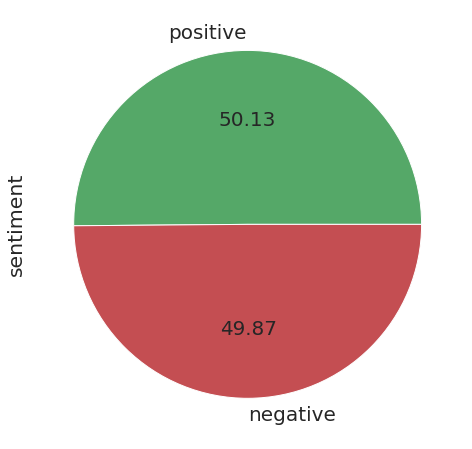

In [ ]:
dataset['sentiment'].value_counts().plot(kind='pie', figsize=(10, 8), autopct='%.2f', fontsize=20, labels = ['positive', 'negative'], colors=['g', 'r'])

Lo siguiente es visualizar que palabras son las más repetidas en cada clase, para ello se tokeniza el texto de la review.

In [ ]:
tokenizer = WhitespaceTokenizer()
dataset_tokenized = training_set.copy()
dataset_tokenized['review'] = training_set['review'].apply(tokenizer.tokenize)

# 10 primeras filas con la review convertida en una lista de tokens sin tratar
dataset_tokenized.head(10)

,id,review,sentiment
0,17527,"[People, tried, to, make, me, believe, that, t...",negative
1,24155,"[I, have, been, wanting, to, see, cut, since, ...",positive
2,21972,"[This, movie, is, terrible., The, suspense, is...",negative
3,4565,"[I, hope, she, can, keep, acting, and, directi...",positive
4,22098,"[I, fell, in, love, with, this, silent, action...",positive
5,5138,"[Shame, Shame, Shame, on, UA/DW, for, what, yo...",negative
6,16932,"[It's, not, very, often, a, movie, can, litera...",positive
7,13181,"[I, was, very, interested, to, see, this, movi...",positive
8,3299,"[It, might, not, be, the, best, movie, of, 200...",positive
9,18982,"[I, went, to, see, the, Omega, Code, with, a, ...",negative


In [ ]:
# Agrupación todos los tokens por clase
grouped = dataset_tokenized.groupby("sentiment").apply(lambda x: x["review"].sum())
grouped_df = pd.DataFrame({"sentiment": grouped.index, "review": grouped.values})
grouped_df

,sentiment,review
0,negative,"[People, tried, to, make, me, believe, that, t..."
1,positive,"[I, have, been, wanting, to, see, cut, since, ..."


La función `plot_most_frequent_words` se utiliza para representar gráficamente las palabras más frecuentes en el dataset, y así poder analizarlas.

In [ ]:
def plot_most_frequent_words(tokens, n_most_frequent=12, label='positive'):
  # Se crea un diccionario de frecuencias para cada palabras de la review positiva y negativa
  counter = Counter(tokens)
  keys = [x[0] for x in counter.most_common(n_most_frequent)]
  values = [x[1] for x in counter.most_common(n_most_frequent)]

  fig = plt.figure(figsize = (10, 8))
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.bar(keys, values, color=['green' if label == 'positive' else 'red'])
  plt.title("Palabras más frecuentes del sentimiento " + label, fontsize=20)

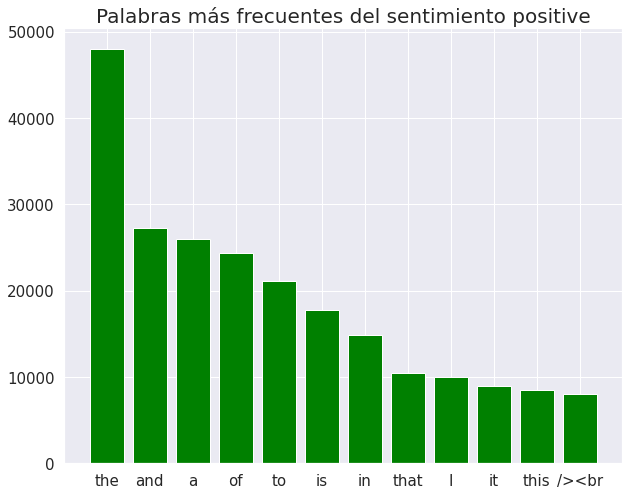

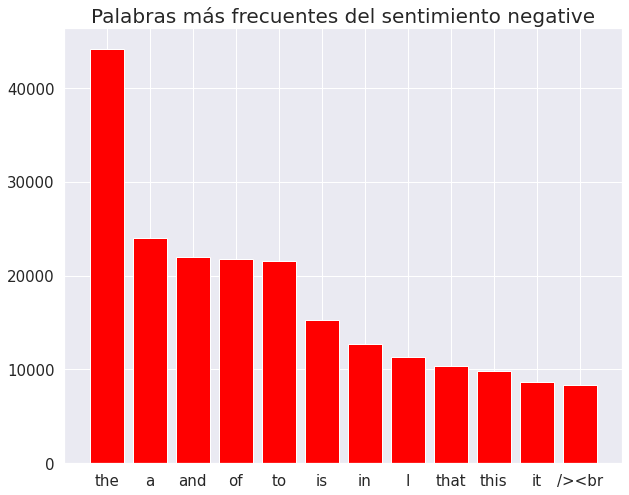

In [ ]:
positive_tokens, negative_tokens = grouped_df[grouped_df['sentiment'] == 'positive']['review'].values.tolist(), grouped_df[grouped_df['sentiment'] == 'negative']['review'].values.tolist()
# El formato es [list]
positive_tokens, negative_tokens = positive_tokens[0], negative_tokens[0]

# Visualización de las 12 palabras más frecuentes para cada clase
plot_most_frequent_words(positive_tokens)
plot_most_frequent_words(negative_tokens, label='negative')

Tal y como se observa, todas las palabras frecuentes en ambas clases son *stopwords*, además de que ambas clases tienen como más frecuentes casi las mismas palabras, por lo que no aportan ningún significado ni detalle sobre el conjunto de datos, ni las diferencias entre ambas clases, por lo que será necesario preprocesar el texto antes de analizarlo.

En esta ocasión, se observa que como el texto ha sido tratado por `WhitespaceTokenizer`, las palabras estan en minúsculas. También ser observa un carácter extraño, `/><br`, que será necesario que eliminar durante el pre-procesado.

## 2. Pre-procesado de datos y representación
Después de haber analizado los datos, es necesario realizar un pre-procesado de éstos, se aplicarán una serie de técnicas:

1. Eliminación de carácteres no alfanuméricos 
2. Eliminación de *stopwords*
3. Lematización
4. *Stemming*

Una vez hecho esto, es necesario representar numéricamente los datos y las etiquetas, utilizando varias técnicas como *Bag of Words* (BOW), *one-hot-vectors*, *Word Embedding*, entre otras.

### 2.1 Pre-procesamiento
En este apartado se tokenizará el texto, llevando a cabo las técnicas descritas anteriormente, como eliminación de *stopwords*, lematización y *stemming*. Todos estos procesos se realizan en la función `process_text`, y posteriormente se aplicará a las reviews.





In [6]:
def process_text(text_serie):
  #Eliminación de carácteres no alfanuméricos y carácter <br \/>
  alphanumeric_text = re.sub("<br \/>", "", text_serie) 
  alphanumeric_text = re.sub("[^0-9a-zA-Z]+", " ", alphanumeric_text) 

  #Conversión texto a minúsculas y tokenización a lista de palabras
  tokens = alphanumeric_text.lower().split()
  
  #Eliminación las stopwords
  stop_words = set(stopwords.words("english")) 
  tokens_without_stopwords = [token for token in tokens if token not in stop_words]
  
  #Lematización
  wordnet_lemmatizer = WordNetLemmatizer()
  tokens_lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens_without_stopwords]
  
  #Stemming
  stemmer = PorterStemmer()
  tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmas]
  
  return tokens_stemmed

dataset["review_processed"] = dataset["review"].apply(process_text)
dataset["review_processed"]

0       [peopl, tri, make, believ, premis, rubbishi, s...
1       [want, see, cut, sinc, day, heard, sometim, la...
2       [movi, terribl, suspens, spent, wait, point, m...
3       [hope, keep, act, direct, sure, task, could, e...
4       [fell, love, silent, action, drama, kurt, russ...
                              ...                        
1995    [order, hold, public, attent, three, hour, tre...
1996    [skeptic, sacrif, preciou, time, watch, film, ...
1997    [lol, deliri, funni, tear, eddi, murphi, impre...
1998    [kinda, interest, movi, trashi, cannib, flick,...
1999    [zodiac, killer, 1, 10, worst, act, ever, real...
Name: review_processed, Length: 10000, dtype: object

Se puede observar como quedan las palabras del texto después de procesamiento.

En este paso ,se encontraron dificultades a la hora de eliminar el carácter  `/><br` de los datos, se utilizaron expresiones regulares pero éstas sólo eliminaban los símbolos, manteniendo las letras `br`, por lo que seguía siendo incorrecto. Debido a que se trataba de un caso específico, se decidió eliminar directamente dicha secuencia.

El siguiente paso es realizar la representación del texto procesado, utilizando diferentes técnicas para posteriormente introducirlo en el modelo que vayamos a entrenar.

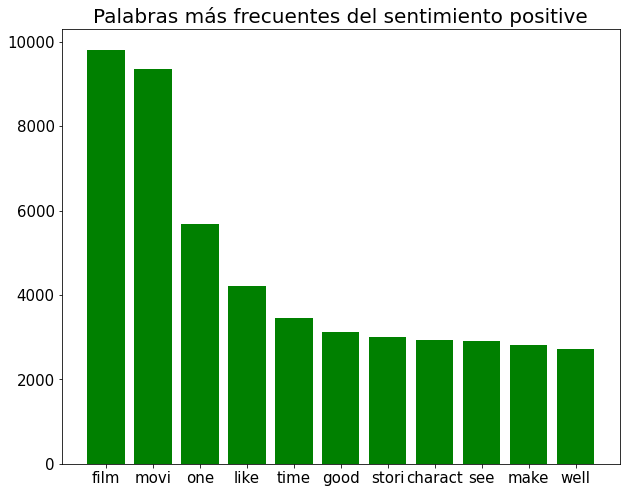

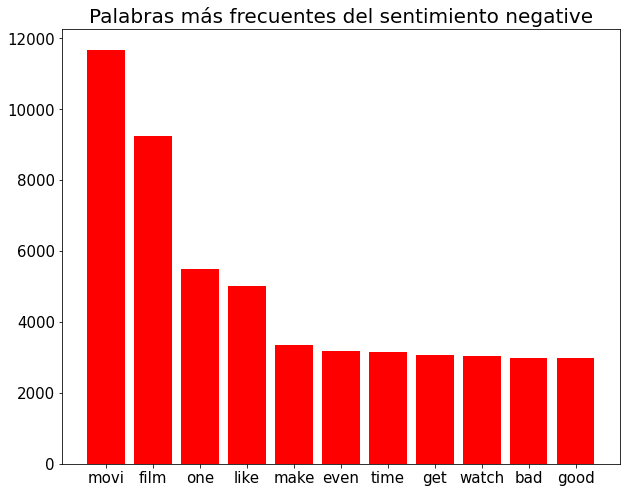

In [ ]:
#Agrupamos todos los tokens por clase
grouped_proc = dataset.groupby("sentiment").apply(lambda x: x["review_processed"].sum())
grouped_proc_df = pd.DataFrame({"sentiment": grouped_proc.index, "review_processed": grouped_proc.values})
positive_tokens_proc = grouped_proc_df[grouped_proc_df['sentiment'] == 'positive']['review_processed'].values.tolist()
negative_tokens_proc = grouped_proc_df[grouped_proc_df['sentiment'] == 'negative']['review_processed'].values.tolist()

#Visualizamos las 11 palabras más frecuentes para cada clase (11 en vez de 12 por motivos de mejor visualización de las palabras)
plot_most_frequent_words(positive_tokens_proc[0], n_most_frequent=11)
plot_most_frequent_words(negative_tokens_proc[0], n_most_frequent=11, label='negative')

Tal y como se observa, las palabras más utilizadas en ambas clases son 'movi', 'film', 'one' y 'like', lo que resulta lógico dado que se trata de un conjunto de datos sobre reviews de películas.

Respecto a las palabras utilizadas en reseñas positivas, destacarían las palabras 'good', 'stori', 'charact', posiblemente descripciones del argumento o los personajes de la película positivamente, junto con 'well'.

Para el caso de las palabras en reseñas negativas, destacaría 'make', 'even', 'time' o 'bad', no tan significativas como en el caso anterior, pero también razonables teniendo en cuenta la naturalez del dataset (podrían ser quejas sobre da duración de la película). Lo sorprendente es que también esta la palabra 'good', lo que podría significar que en la reseña negativa podría haber una parte positiva.

### 2.2 Representación
Una vez se ha obtenido y procesado el conjunto de tokens de cada review, el siguiente paso es representar con valores tanto las palabras como las etiquetas, para introducir en el modelo que se entrene en los apartados siguientes.

Para el caso de las etiquetas, debido a que se trata de una clasificación binaria (entre 2 clases), es razonable utilizar una representación de 1s y 0s.

Para el caso del texto, se han seleccionado tres representaciones:

*   *One-hot vectors*
*   *Bag Of Words (BOW)*
*   *Word Embeddings*

Se escogieron dichas representaciones para hacer un análisis de los resultados desde el modelos más sencillos (one-hot) hasta modelos más complejos, que requieren un entrenamiento extra, como es el caso de los *Word Embeddings*.

La función `add_pading` se utiliza para los casos en los cuales es necesario igualar el tamaño del vector de características para los conjuntos de entrenamiento y test. En este caso es necesario añadir columnas a los datos de test, para igualarlos con los datos de entrenamiento.

In [ ]:
def add_padding(x_train, x_test):
  test_rows = x_test.shape[0]
  train_features = x_train.shape[1]
  test_features = x_test.shape[1]
  padding = train_features-test_features

  return np.concatenate((x_test, np.zeros((test_rows, padding), dtype=int)), axis=1)

La función `extract_100_best_features` se utiliza para entraer las 100 mejores características de la representación que se haya realizado, esto sirve para en primer lugar reducir el tamaño de las muestras, por lo que aumenta la velocidad de entrenamiento del modelo, además de mejorar su precisión y *recall*, ya que se trata de un modelo más compacto.

In [ ]:
def extract_100_best_features(X_train, X_test):
  x_train_100_features = SelectKBest(chi2, k=100).fit_transform(X_train, binary_y_train)
  x_test_100_features = SelectKBest(chi2, k=100).fit_transform(X_test, binary_y_test)
  return x_train_100_features, x_test_100_features

In [7]:
# Se vuelve a separar los datos en entrenamiento y test
X_train = dataset[0:len(training_set)][["id", "review_processed"]]
y_train = dataset[0:len(training_set)][["sentiment"]]
X_test = dataset[len(training_set):len(dataset)][["id", "review_processed"]]
y_test = dataset[len(training_set):len(dataset)][["sentiment"]]

# Se transforman las etiquetas a valores numéricos, para esre caso, clases binarias 0 (negativo) y 1 (positivo)
le = preprocessing.LabelEncoder()
binary_y_train = le.fit_transform(y_train['sentiment'].values)
binary_y_test = le.fit_transform(y_test['sentiment'].values)

**Representación One-hot vectors**

Para realizar dicha representación se utiliza `MultiLabelBinarizer` debido a que cada review está representada como un conjunto de palabras, es decir, cada review sería un vector one-hot.

In [ ]:
ohe = preprocessing.MultiLabelBinarizer()
one_hot_x_train = ohe.fit_transform(X_train['review_processed'].values)
print(one_hot_x_train.shape)
one_hot_x_test = ohe.fit_transform(X_test['review_processed'].values)
print(one_hot_x_test.shape)

# Como el tamaño de las features de test, no es igual de grande de el conjunto de entrenamiento, 
# es necesario aplicar un padding para que ambas tengan el mismo numero de características
one_hot_x_test = add_padding(one_hot_x_train, one_hot_x_test)
print(one_hot_x_test.shape)

(8000, 32180)
(2000, 17367)
(2000, 32180)


In [ ]:
one_hot_x_train_100_features, one_hot_x_test_100_features = extract_100_best_features(one_hot_x_train, one_hot_x_test)

**Representación Bag of words**

Para realizar dicha representación se utiliza `CountVectorizer` para transformar las reviews a vectores bag of words, con la frecuencia de cada palabra.

In [ ]:
cv = CountVectorizer(analyzer=lambda x: x)
bow_x_train = cv.fit_transform(X_train['review_processed']).toarray()
bow_x_test = cv.fit_transform(X_test['review_processed']).toarray()

bow_x_test = add_padding(one_hot_x_train, one_hot_x_test)

In [ ]:
bow_x_train_100_features, bow_x_test_100_features = extract_100_best_features(bow_x_train, bow_x_test)

**Representación Word Embedding**

La representación Word Embeddings se puede realizar por principalmente mediante tres modelos:


*   Word2Vec
*   GloVe
*   FastText

En este caso se escogió probar las representaciones mediante Word2Vec, y FastText, debido a que ésta última funciona mejor para corpus de pequeño tamaño, y es especialmente bueno en la representación de palabras poco frecuentes. 

También se trató de utilizar Glove, pero se encontraron dificultades para poder utilizarlo, ya que era necesario instalar la librería, o bien descargar el código de github, y la documentación era bastante escasa, además de que era complicado entrenar un modelo desde 0, por lo que se descartó la posibilidad de utilizar GloVe. Además de esto, tanto Word2Vec como FastText están implementados con la librería Gensim, lo que facilita el entendimiento del código.

Cabe destacar también que en el caso de utilizar Redes Neuronales, no sería necesario entrenar un modelo de Word Embeddings como tal, ya que se puede entrenar en la propia red.

En primer lugar, se prueba con Word2Vec, utilizando la libreróa Gensim. Este modelo se puede entrenar mediante dos aproximaciones:

*   Continuous Bag of Words Model (CBWM)
*   Skip-gram



**Continuous Bag of Words**

Las palabras se representan mediante one-hot-vectors, representando el contexto de cada palabra, como el vector media de un número definido de palabras al rededor de la palabra principal (ventana), y el modelo trata de predecir la palabra principal en base a dicho contexto.
Normalmente utilizado para representaciones con corpus de tamaño medio o grande, debido a que es un bueno modelo para representar las palabras más frecuentes.

In [ ]:
w2v_cbow = Word2Vec(sentences=X_train['review_processed'].values, 
                    size=100, # Dimension de los embedding, normalmente entre 100 y 300 dimesiones
                    window=5, # Ventana de número de palabras que se consideran contexto
                    min_count=1, # Frecuencia mínima que tiene que tener una palabra para ser representada
                    workers=4, # Número de hilos que se van a utilizar (como máximo el numero de cores de la máquina)
                    sg=0, # Si = 0, es cbow, si = 1 skipgram
                    compute_loss=True) # Calcula la loss del entrenamiento
w2v_cbow_loss = w2v_cbow.get_latest_training_loss()

In [ ]:
# Se pueden ver las palabras más similares del vocabulario
w2v_cbow.wv.most_similar('film', topn=5)

[('movi', 0.8874729871749878),
 ('pictur', 0.8647301197052002),
 ('documentari', 0.8530716300010681),
 ('piec', 0.8360216021537781),
 ('effort', 0.8329089879989624)]

En este ejemplo ser puede observar que los resultados no son demasiado satisfactorios, ya que la palabra más cercana si es correcta (movi), pero las otras 4 palabras distan bastante de la palabra film.

**Skip-gram**

Parecido al modelo CBOW, pero en este caso se pretende predecir el contexto, dada una palabra. Generalmente funciona mejor en corpus de tamaño pequeño, ya que representa bastante bien palabras raras o poco frecuentes.

In [ ]:
w2v_skipgram = Word2Vec(sentences=X_train['review_processed'].values, 
                        size=100, 
                        window=5, 
                        min_count=1, 
                        workers=4, 
                        sg=1,
                        compute_loss=True)
w2v_skipgram_loss = w2v_skipgram.get_latest_training_loss()

In [ ]:
w2v_skipgram.wv.most_similar('film', topn=5)

[('movi', 0.8963095545768738),
 ('nonetheless', 0.82961106300354),
 ('shocker', 0.8294177651405334),
 ('puzzl', 0.8279708027839661),
 ('awe', 0.8239459991455078)]

En este ejemplo, parece que los resultados tampoco son satisfactorios. Dado que se trata de modelos de aprendizaje no supervisado, la evaluación de los modelos se vuelve complicada. De forma que se ha calculado el loss en ambos ejemplos, para ver cual de ambas aproximaciones, con los mismos parámetros, tiene menor pérdida.

Text(0.5, 1.0, 'Loss Word2Vec')

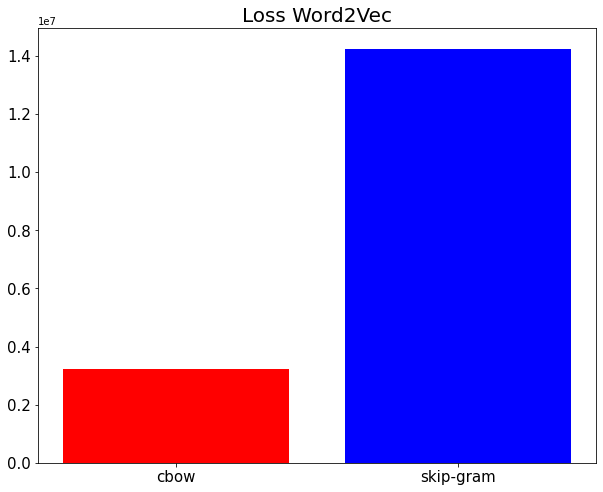

In [ ]:
fig = plt.figure(figsize = (10, 8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.bar(["cbow", "skip-gram"], [w2v_cbow_loss, w2v_skipgram_loss], color=['red', 'blue'])
plt.title("Loss Word2Vec", fontsize=20)

Tal y como se observa en la gráfica, el modelo realizado con cbow tiene menor pérdida, por tanto es mejor en comparación con el modelo skip-gram. De igual forma, vistos los resultados de cálcula similitudes con la palabra 'film' ambos modelos parecen no ser demasiado precisos.

**FastText**

Para este modelo, también es posible trabajar con ambas aproximaciones. 
En primer lugar, se relizó un modelo con CBOW, y en segundo lugar el Skip-gram, para este modelo, no es posible calcular la pérdida, por lo que no podemos basarnos en este parámetro a la hora de comparar los modelos, si no sólo en los resultados de las similitudes.

In [ ]:
ft_cbow = FastText(X_train['review_processed'].values, 
                   size=100, 
                   window=5, 
                   min_count=5, 
                   workers=4)

In [ ]:
ft_cbow.wv.most_similar('film', topn=5)

[('filmak', 0.950358510017395),
 ('filmic', 0.9235193133354187),
 ('unfilm', 0.917396068572998),
 ('file', 0.8617141842842102),
 ('filmmak', 0.8578383326530457)]

In [28]:
ft_skipgram = FastText(X_train['review_processed'].values, 
                       size=100, 
                       window=5, 
                       min_count=5, 
                       workers=4, 
                       sg=1)

In [ ]:
ft_skipgram.wv.most_similar('film', topn=5)

[('filmak', 0.8975878953933716),
 ('unfilm', 0.8537160158157349),
 ('filmic', 0.8466314673423767),
 ('movi', 0.8235632181167603),
 ('mockumentari', 0.7759813666343689)]

Para el caso de los modelos de FastText, ambos parecen tener mejores resultados que los modelos Word2Vec, si se observan las palabras más similares de 'film', se encuentran palabras que comparten raiz, como 'filmak' y 'filmic', así como también 'unfilm' o 'movi', lo que son resultamos bastante buenos en cuanto a similitudes de palabras.

Por este motivo, se puede asumir que para este corpus, funciona mejor el modelo de word embedding FastText. Aunque también cierto que sería interesante estudiar el modelo con distintos parámetros.

## 3. Modelos básicos de Machine Learning

Una vez realizado el pre-procesamiento y representación de los datos, se puede empezar a pensar en un modelo apropiado para realizar la tarea de Clasificación. En primer lugar se plantea utilizar una serie de modelos clásicos de Machine Learning.
Los modelos seleccionados son los siguientes:

*   Regresión Logística
*   Random Forest
*   Perceptrón

La razón de escoger dichos modelos es la siguiente; En primer lugar, se seleccionó la Regresión Logística debido a que es un modelo probabilistico muy util en clasificaciones binarias, como es el caso. Además de ello, es un modelo clásico, y se pensó que sería interesante ver su funcionamiento en este caso.

En segundo lugar, se utilizó Random Forest debido a que es un modelo construido en base a varios modelos "débiles", en este caso Árboles de decisión. El modelo se construye aplicando una técnica llamada *bagging*, que se basa en la combinación de resultados de varios clasificadores, para así obtener un modelo más robusto.

Por último, se escogió Perceptrón debido a que se trata de la forma más simple de una red neuronal, con una única capa y neurona; es utilizado para la clasificación, por lo que sería interensate ver sus resultados, para posteriormente, compararlos con los modelos de Redes Neuronales que se entrenen en el apartado siguiente.


La función  `train_best_classifier` utiliza un grid, para probar a entrenar un modelo con un conjunto variable de parámetros, y así seleccionar el mejor modelo entre dichos parámetros.

In [ ]:
def train_best_classifier(X, y, model, params):
  # Creación clasificador con los parametros que se quieren probar
  classifier = GridSearchCV(estimator=model,  
                            param_grid=params, 
                            error_score=0.0, 
                            n_jobs = 1, # Se tuvo que poner a 1 único hilo por que si no el entorno terminaba con el proceso
                            verbose = 1)
  # Introducción de datos y entrenamiento
  classifier.fit(X, y)
  
  means = classifier.cv_results_['mean_test_score']
  stds = classifier.cv_results_['std_test_score']
  for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
      print("Mean test score: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
  print()

  return classifier

La función  `evaluate_classifier` es utilizada para evaluar el modelo con las métricas clasicas de precisión, *recall* y *f1score*.

In [ ]:
def evaluate_classifier(X, y, model, name):
  yhat = model.predict(X)
  precision, recall, f1score, _ = precision_recall_fscore_support(y, yhat)
  print("Class POSITIVE: Precision: %0.3f Recall %0.3f F1 score: %0.3f for %s" % (precision[0], recall[0], f1score[0], name))
  print("Class NEGATIVE: Precision: %0.3f Recall %0.3f F1 score: %0.3f for %s" % (precision[1], recall[1], f1score[1], name))
  return precision, recall, f1score

En este apartado de extraen los vectores de cada review, realizando una media de los vectores de las palabras que forman parte de dicha review.
El modelo de *Word Embedding* utilizado es el modelo FastText, debido a que es el de mejores resultados.

In [29]:
def words_to_vector(words):
  review = [w for w in words if w in ft_skipgram.wv.vocab]
  return np.mean(ft_skipgram[review], axis=0, dtype=float)

In [30]:
X_train['review_vectors'] = X_train['review_processed'].apply(words_to_vector)
X_test['review_vectors'] = X_test['review_processed'].apply(words_to_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


La función `plot_stats` se utiliza para graficar los resultados de la evaluación de los distintos modelos que se hayan utilizado.

In [8]:
metric, class_, model = ['precision'] * 3 + ['recall'] * 3 + ['f1score'] * 3 + ['precision'] * 3 + ['recall'] * 3 + ['f1score'] * 3, \
                        ['positive'] * 9 + ['negative'] * 9, \
                        ['one-hot', 'bow', 'fasttext'] * 6, \

def plot_stats(value, model=model, class_=True):
  sns.set(font_scale=1.70)
  c = 2
  if class_:
    df_stats = pd.DataFrame(list(zip(metric, class_, model, value)), columns =['Metric', 'Class', 'Model', 'Value'])
    g = sns.catplot(x="Metric", y="Value", hue="Model", col="Class", data=df_stats, kind="bar", height=8.27)
  else:
    df_stats = pd.DataFrame(list(zip(metric, model, value)), columns =['Metric', 'Model', 'Value'])
    g = sns.catplot(x="Metric", y="Value", hue="Model", data=df_stats, kind="bar", height=8.27)
    c = 1

  for i in np.arange(c):
    ax = g.facet_axis(0, i)
    for p in ax.patches:
        ax.text(p.get_x() + 0.015, p.get_height() * 1.02, 
                '{0:.2f}'.format(p.get_height()), 
                color='black', rotation='horizontal', size='medium')

### Regresión Lógica

En primer lugar, probamos a entrenar el modelo con las features obtenidas del preproceso en one-hot-vector. Se escogieron los parámetros del modelo más reelevantes, como la penalización (regularización), estando también relacionado con el parámetro C, que se utiliza para tratar de controlar el sobre-entrenamiento.

In [ ]:
params_logistic_regresion = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]} # Penalty l1 no era reconocido
logisitc_regresion_one_hot = train_best_classifier(one_hot_x_train, binary_y_train, LogisticRegression(), params_logistic_regresion)

In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/logistic_regresion_ohv.sav'
pickle.dump(logisitc_regresion_one_hot, open(filename, 'wb'))

In [ ]:
# Se carga el modelo de disco para evitar tener que repetir la ejecución
logisitc_regresion_ohv = pickle.load(open('/content/drive/My Drive/models/logistic_regresion_ohv.sav', 'rb'))

In [ ]:
p_log_one_hot, r_log_one_hot, f1_log_one_hot = evaluate_classifier(one_hot_x_test, binary_y_test, logisitc_regresion_ohv, "Logisitc Regresion")

Class POSITIVE: Precision: 0.487 Recall 0.458 F1 score: 0.472 for Logisitc Regresion
Class NEGATIVE: Precision: 0.463 Recall 0.492 F1 score: 0.477 for Logisitc Regresion


Tal y como se observa, el mejor resultado del entrenamiento se obtiene con C = 0.1 y penalty = l2, sin embargo, al evaluar el modelo se ven resultados no muy satisfactorios, de precisión, *recall* y *f1score* por debajo de 0.5.

En segundo lugar, se realiza entrena el modelo con los datos representados mediante *bag of words*.

In [ ]:
params_logistic_regresion = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]} # Penalty l1 no era reconocido
logisitc_regresion_bow = train_best_classifier(bow_x_train, binary_y_train, LogisticRegression(), params_logistic_regresion)

De nuevo, los mejores resultados se obtienen con los parámetros C = 0.1 y penalty = l2

In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/logistic_regresion_bow.sav'
pickle.dump(logisitc_regresion_bow, open(filename, 'wb'))

In [ ]:
logistic_regresion_bow = pickle.load(open('/content/drive/My Drive/models/logistic_regresion_bow.sav', 'rb'))

In [ ]:
p_log_bow, r_log_bow, f1_log_bow = evaluate_classifier(bow_x_test, binary_y_test, logistic_regresion_bow, "Logisitc Regresion")

Class POSITIVE: Precision: 0.489 Recall 0.518 F1 score: 0.503 for Logisitc Regresion
Class NEGATIVE: Precision: 0.459 Recall 0.430 F1 score: 0.444 for Logisitc Regresion


En esta ocasión se puede ver que los resultados son ligeramente mejores que con one-hot, aún así, siguen siendo insatisfactorios.

A continuación se prueba a entrenar el modelo con los parámetros óptimos, y la representación del modelo FastText.

In [ ]:
params_logistic_regresion = {'penalty': ['l2'], 'C': [0.1]} # Penalty l1 no era reconocido
logisitc_regresion_wv = train_best_classifier(X_train['review_vectors'].tolist(), binary_y_train, LogisticRegression(), params_logistic_regresion)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean test score: 0.810 (+/-0.020) for params: {'C': 0.1, 'penalty': 'l2'}



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [ ]:
p_log_wv, r_log_wv, f1_log_wv = evaluate_classifier(X_test['review_vectors'].tolist(), binary_y_test, logisitc_regresion_wv, "Logisitc Regresion")

Class POSITIVE: Precision: 0.838 Recall 0.808 F1 score: 0.823 for Logisitc Regresion
Class NEGATIVE: Precision: 0.805 Recall 0.836 F1 score: 0.820 for Logisitc Regresion


En esta ocasión los resultados son bastante buenos, con unos valores de evaluación mayores de 80%. 

A continuación se muestra una gráfica con la comparativa de resultados del modelo de Regresión Lógica para los tres tipos de representaciones del texto. Se puede ver que la representación de Word Embedding es muy superior a las demás. Esto puede explicarse debido a que los modelos vectoriales de one-hot-encoding y bow son más sencillos y no se basan en el contexto, como si lo hace word embeddings. 

También se observa que los valores de evaluación se mantienen en ambas clases.


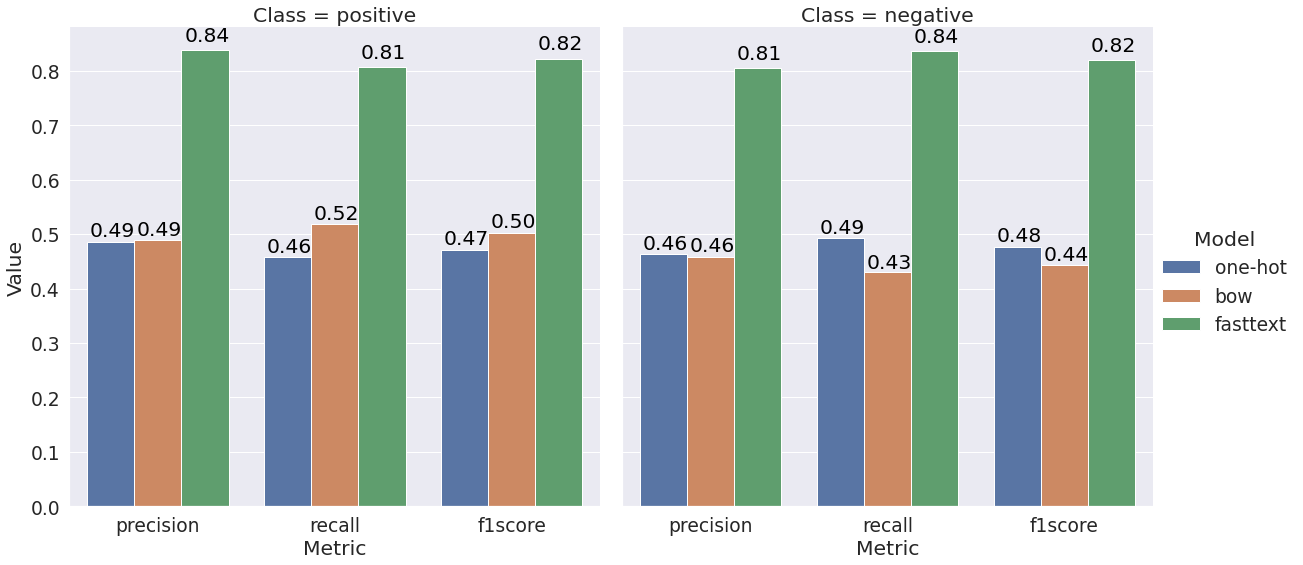

In [ ]:
value = [p_log_one_hot[0], p_log_bow[0], p_log_wv[0], r_log_one_hot[0], r_log_bow[0], r_log_wv[0], f1_log_one_hot[0], f1_log_bow[0], f1_log_wv[0], \
        p_log_one_hot[1], p_log_bow[1], p_log_wv[1], r_log_one_hot[1], r_log_bow[1], r_log_wv[1], f1_log_one_hot[1], f1_log_bow[1], f1_log_wv[1]]
plot_stats(value)

### Random Forest

Para entrenar el modelo de Random Forest, en primer lugar se probo con los parametros max_depth, es decir, profundidad del árbol (por defecto, sin límite de profundidad) y bootstrap (si es falso, se utilizan todas las muestras para entrenar todos los árboles, por defecto es verdadero) pero se observó que los resultados por defecto eran mejores (sin profundidad máxima y con bootsrap) así que se probó otro parámetro, el criterio por el cual se evalúa la separación en el arbol de decisión, al parece funcionar mejor el criterio de la entropía.

In [ ]:
params_random_forest = {'criterion' : ['gini', 'entropy']}
random_forest_ohv = train_best_classifier(one_hot_x_train, binary_y_train, RandomForestClassifier(), params_random_forest)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.6min finished


Mean test score: 0.844 (+/-0.012) for params: {'criterion': 'entropy'}
Mean test score: 0.838 (+/-0.018) for params: {'criterion': 'gini'}



In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/random_forest_ohv.sav'
pickle.dump(random_forest_ohv, open(filename, 'wb'))

In [ ]:
random_forest_ohv = pickle.load(open('/content/drive/My Drive/models/random_forest_ohv.sav', 'rb'))

In [ ]:
p_rf_ohv, r_rf_ohv, f1_rf_ohv = evaluate_classifier(one_hot_x_test, binary_y_test, random_forest_ohv, "Random Forest")

Class POSITIVE: Precision: 0.536 Recall 0.059 F1 score: 0.106 for Random Forest
Class NEGATIVE: Precision: 0.489 Recall 0.947 F1 score: 0.645 for Random Forest


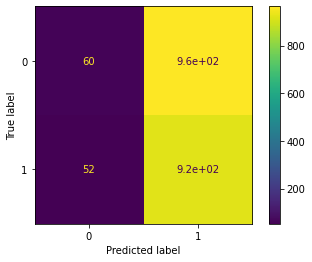

In [ ]:
plot_confusion_matrix(random_forest_ohv, one_hot_x_test, binary_y_test)  

Se puede observar unos resultados muy dispares, entre ambas clases para el caso del *recall*. Si se muestra una gráfica de la matriz de confusión, se ve claramente que ha predicho de manera incorrecta la etiqueta positiva en prácticamente todos los casos, de ahi su baja puntuación de *recall*.

A continuación se prosigue con la representación de BOW.

In [ ]:
random_forest_bow = train_best_classifier(bow_x_train, binary_y_train, RandomForestClassifier(), params_random_forest)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.9min finished


Mean test score: 0.844 (+/-0.013) for params: {'criterion': 'entropy'}
Mean test score: 0.837 (+/-0.016) for params: {'criterion': 'gini'}



In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/random_forest_bow.sav'
pickle.dump(random_forest_bow, open(filename, 'wb'))

In [ ]:
random_forest_bow = pickle.load(open('/content/drive/My Drive/models/random_forest_bow.sav', 'rb'))

In [ ]:
p_rf_bow, r_rf_bow, f1_rf_bow = evaluate_classifier(bow_x_test, binary_y_test, random_forest_bow, "Random Forest")

Class POSITIVE: Precision: 0.523 Recall 0.056 F1 score: 0.101 for Random Forest
Class NEGATIVE: Precision: 0.488 Recall 0.947 F1 score: 0.644 for Random Forest


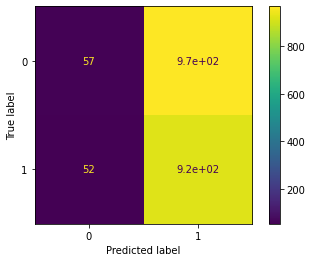

In [ ]:
plot_confusion_matrix(random_forest_bow, bow_x_test, binary_y_test) 

Parece ser que se repite el proceso anterior, donde casi todos los datos se clasifican como positivos.

Ahora se entrenará el modelo con Word Embedding.

In [ ]:
params_random_forest = {'criterion' : ['entropy']}
random_forest_wv = train_best_classifier(X_train['review_vectors'].tolist(), binary_y_train, RandomForestClassifier(), params_random_forest)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.5s finished


Mean test score: 0.810 (+/-0.009) for params: {'criterion': 'entropy'}



In [ ]:
p_rf_wv, r_rf_wv, f1_rf_wv = evaluate_classifier(X_test['review_vectors'].tolist(), binary_y_test, random_forest_wv, "Random Forest")

Class POSITIVE: Precision: 0.825 Recall 0.819 F1 score: 0.822 for Random Forest
Class NEGATIVE: Precision: 0.811 Recall 0.817 F1 score: 0.814 for Random Forest


Tal y como se observa, parece ser que la representación con embeddings sigue funcionando muy bien con el modelo de Random Forest, de igual forma que con la Regresión Logística.

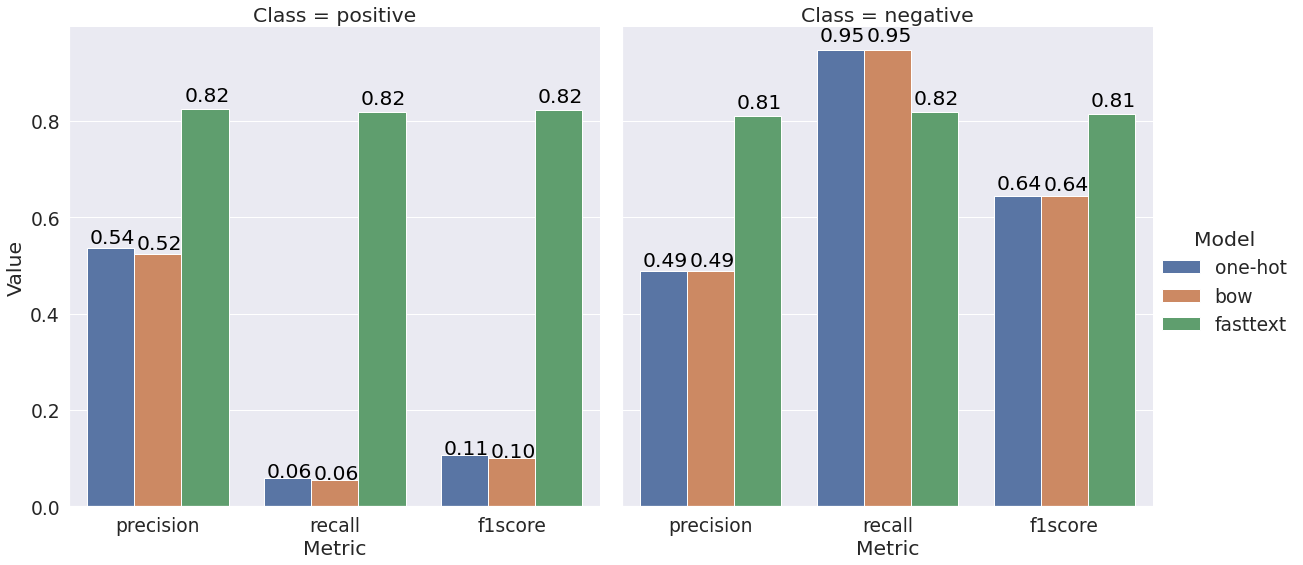

In [ ]:
value = [p_rf_ohv[0], p_rf_bow[0], p_rf_wv[0], r_rf_ohv[0], r_rf_bow[0], r_rf_wv[0], f1_rf_ohv[0], f1_rf_bow[0], f1_rf_wv[0], \
        p_rf_ohv[1], p_rf_bow[1], p_rf_wv[1], r_rf_ohv[1], r_rf_bow[1], r_rf_wv[1], f1_rf_ohv[1], f1_rf_bow[1], f1_rf_wv[1]]
plot_stats(value)

Trás analizar el problema de la matriz de confusión, se llegó a la conclusión de que podría ser debido a que las clases están muy balanceadas, y el modelo de Random Forest es más utilizado para casos en los que las clases sean desbalanceadas.

Además de ésto, los modelos se entrenaban muy lento (entre 10 y 15 minutos) a diferencia del modelo con embeding, que tardaba menos, por esto mismo, se decidió aplicar una reducción de dimensionalidad a los datos representados con one-hot y bow, escogiendo las 100 caraceterísticas más significativas. Aplicando la función `extract_100_best_features` descrita anteriormente.

In [ ]:
random_forest_bow = train_best_classifier(bow_x_train_100_features, binary_y_train, RandomForestClassifier(), {'criterion' : ['entropy']})
p_rf_bow, r_rf_bow, f1_rf_bow = evaluate_classifier(bow_x_test_100_features, binary_y_test, random_forest_bow, "Random Forest")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


Mean test score: 0.815 (+/-0.003) for params: {'criterion': 'entropy'}

Class POSITIVE: Precision: 0.526 Recall 0.736 F1 score: 0.614 for Random Forest
Class NEGATIVE: Precision: 0.522 Recall 0.304 F1 score: 0.384 for Random Forest


In [ ]:
random_forest_ohv = train_best_classifier(one_hot_x_train_100_features, binary_y_train, RandomForestClassifier(), {'criterion' : ['entropy']})
p_rf_ohv, r_rf_ohv, f1_rf_ohv = evaluate_classifier(one_hot_x_test_100_features, binary_y_test, random_forest_ohv, "Random Forest")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


Mean test score: 0.811 (+/-0.012) for params: {'criterion': 'entropy'}

Class POSITIVE: Precision: 0.513 Recall 0.759 F1 score: 0.612 for Random Forest
Class NEGATIVE: Precision: 0.490 Recall 0.243 F1 score: 0.325 for Random Forest


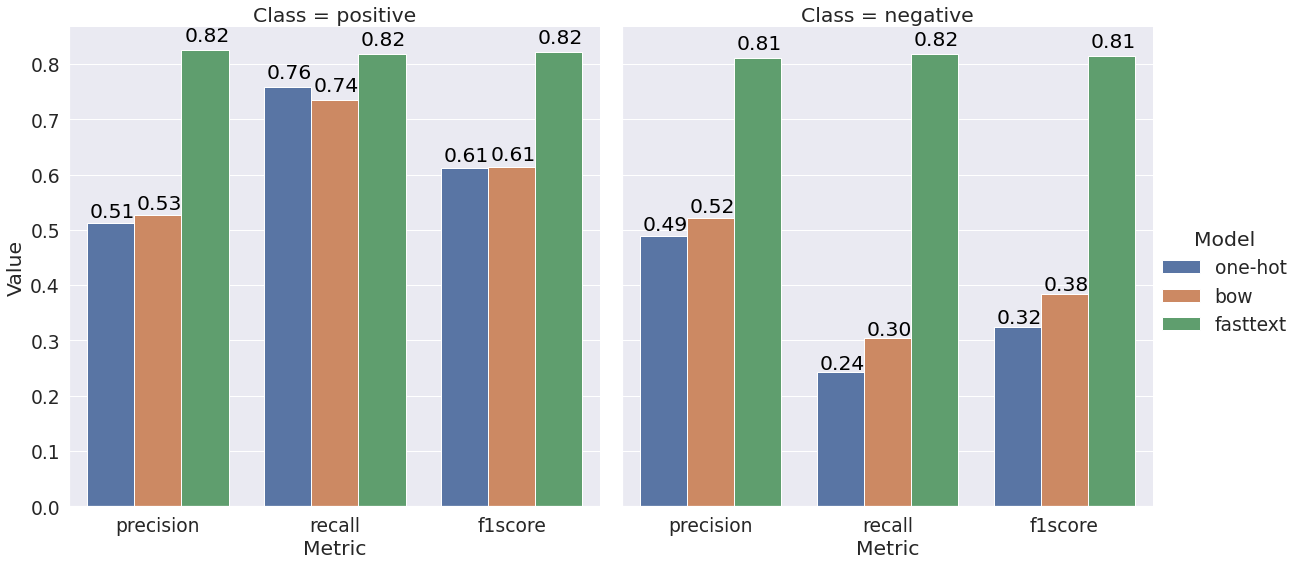

In [ ]:
value = [p_rf_ohv[0], p_rf_bow[0], p_rf_wv[0], r_rf_ohv[0], r_rf_bow[0], r_rf_wv[0], f1_rf_ohv[0], f1_rf_bow[0], f1_rf_wv[0], \
        p_rf_ohv[1], p_rf_bow[1], p_rf_wv[1], r_rf_ohv[1], r_rf_bow[1], r_rf_wv[1], f1_rf_ohv[1], f1_rf_bow[1], f1_rf_wv[1]]
plot_stats(value)

De esta forma, si bien no se consiguió acabar del todo con el problema del desbalanceo de clases, se redujo bastante al reducir las dimensiones de los datos de entrenamiento, además de mejorar en todos los aspectos.

### Perceptrón

Por último, se aplicará el modelo perceptrón, con los parámetros a variar: 
*   early_stopping, indicando si el modelo debe parar el entrenamiento si se produce una bajada en el *score*.
*   penalty, ya visto anteriormente.
*   alpha, parecido a un factor de aprendizaje

Tras lo observado en el caso anterior, para entrenar el modelo Perceptrón se utilizaron directamente los datos con las 100 mejores características.

In [ ]:
params_perceptron = {'early_stopping' : [False, True], 'penalty' : ['l2', 'l1'], 'alpha' : [0.0001, 0.001]}
perceptron_ohv = train_best_classifier(one_hot_x_train_100_features, binary_y_train, Perceptron(), params_perceptron)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean test score: 0.780 (+/-0.050) for params: {'alpha': 0.0001, 'early_stopping': False, 'penalty': 'l2'}
Mean test score: 0.771 (+/-0.055) for params: {'alpha': 0.0001, 'early_stopping': False, 'penalty': 'l1'}
Mean test score: 0.767 (+/-0.035) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.748 (+/-0.066) for params: {'alpha': 0.001, 'early_stopping': False, 'penalty': 'l1'}
Mean test score: 0.742 (+/-0.042) for params: {'alpha': 0.001, 'early_stopping': False, 'penalty': 'l2'}
Mean test score: 0.742 (+/-0.064) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l2'}
Mean test score: 0.731 (+/-0.032) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.707 (+/-0.059) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l2'}



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.4s finished


In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/perceptron_ohv.sav'
pickle.dump(perceptron_ohv, open(filename, 'wb'))

In [ ]:
p_per_ohv, r_per_ohv, f1_per_ohv = evaluate_classifier(one_hot_x_test_100_features, binary_y_test, perceptron_ohv, "Perceptron")

Class POSITIVE: Precision: 0.520 Recall 0.705 F1 score: 0.599 for Perceptron
Class NEGATIVE: Precision: 0.505 Recall 0.316 F1 score: 0.389 for Perceptron


En esta ocasión tambien se observa un pequeño desbalance entre ambas clases.

In [ ]:
params_perceptron = {'early_stopping' : [False, True], 'penalty' : ['l2', 'l1'], 'alpha' : [0.0001, 0.001]}
perceptron_bow = train_best_classifier(bow_x_train_100_features, binary_y_train, Perceptron(), params_perceptron)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean test score: 0.779 (+/-0.030) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.775 (+/-0.047) for params: {'alpha': 0.0001, 'early_stopping': False, 'penalty': 'l1'}
Mean test score: 0.766 (+/-0.060) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l2'}
Mean test score: 0.761 (+/-0.046) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.757 (+/-0.038) for params: {'alpha': 0.001, 'early_stopping': False, 'penalty': 'l1'}
Mean test score: 0.738 (+/-0.091) for params: {'alpha': 0.0001, 'early_stopping': False, 'penalty': 'l2'}
Mean test score: 0.733 (+/-0.046) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l2'}
Mean test score: 0.707 (+/-0.073) for params: {'alpha': 0.001, 'early_stopping': False, 'penalty': 'l2'}



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.1s finished


In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/perceptron_bow.sav'
pickle.dump(perceptron_bow, open(filename, 'wb'))

In [ ]:
p_per_bow, r_per_bow, f1_per_bow = evaluate_classifier(bow_x_test_100_features, binary_y_test, perceptron_bow, "Perceptron")

Class POSITIVE: Precision: 0.554 Recall 0.640 F1 score: 0.594 for Perceptron
Class NEGATIVE: Precision: 0.547 Recall 0.457 F1 score: 0.498 for Perceptron


Para el caso de Bow se observan unos resultados parecidos a los obtenidos en Regresión Logistica, y superiores a los obtenidos en la representación one-hot.

In [ ]:
params_perceptron = {'early_stopping' : [True], 'penalty' : ['l1'], 'alpha' : [0.0001]}
perceptron_wv = train_best_classifier(X_train['review_vectors'].tolist(), binary_y_train, Perceptron(), params_perceptron)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean test score: 0.712 (+/-0.150) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l1'}



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [ ]:
p_per_wv, r_per_wv, f1_per_wv = evaluate_classifier(X_test['review_vectors'].tolist(), binary_y_test, perceptron_wv, "Perceptron")

Class POSITIVE: Precision: 0.787 Recall 0.906 F1 score: 0.843 for Perceptron
Class NEGATIVE: Precision: 0.883 Recall 0.743 F1 score: 0.807 for Perceptron


Con la utlización de word embeddings, los resultados son bastante positivos, como en los dos modelos anteriores.

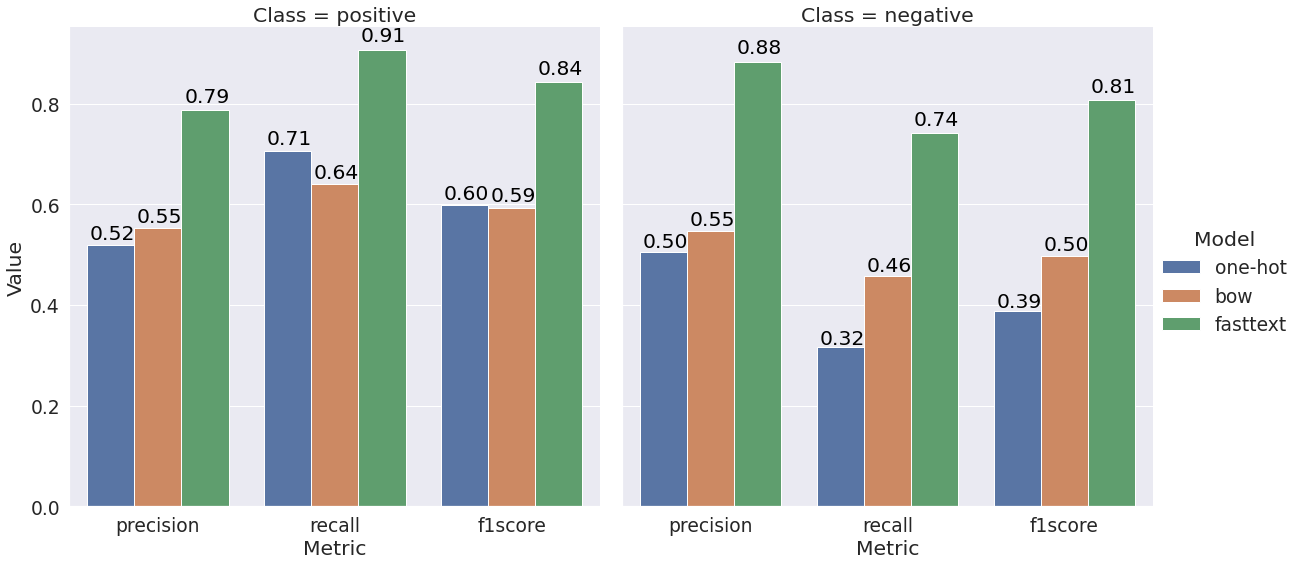

In [ ]:
value = [p_per_ohv[0], p_per_bow[0], p_per_wv[0], r_per_ohv[0], r_per_bow[0], r_per_wv[0], f1_per_ohv[0], f1_per_bow[0], f1_per_wv[0], \
        p_per_ohv[1], p_per_bow[1], p_per_wv[1], r_per_ohv[1], r_per_bow[1], r_per_wv[1], f1_per_ohv[1], f1_per_bow[1], f1_per_wv[1]]
plot_stats(value)

En la gráfica de resultados, se ve claramente que la representación de embeddings es la que mejores resultados obtiene, seguido de la representación bow, y la one-hot, cosa lógica debido a que cuanto más representativas son las características, mejores resultados proporcionan.

### Comparación de modelos

Como conclusión final de los modelos clásicos de ML, los resultados obtenidos con representación de embeddings, son bastante similares en los tres modelos. Si nos basamos en la métrica *f1score* como la más completa, tal vez se podría decir que Perceptrón es ligeramente superior a los dos anteriores modelos.

Sin embargo, en mi opinión, a pesar de que los resultados no son muy buenos (con las otras dos representaciones) diría que el mejor modelo fue Regresión Logística, ya que las métricas obtuvieron puntuaciones similares en ambas clases, sin producir desbalances. Tal vez debido a que se trata de un modelo utilizado en clasificación binaria.

A continuación se muestra una gráfica con las métrica de cada modelo para la representación word embedding con FastText.

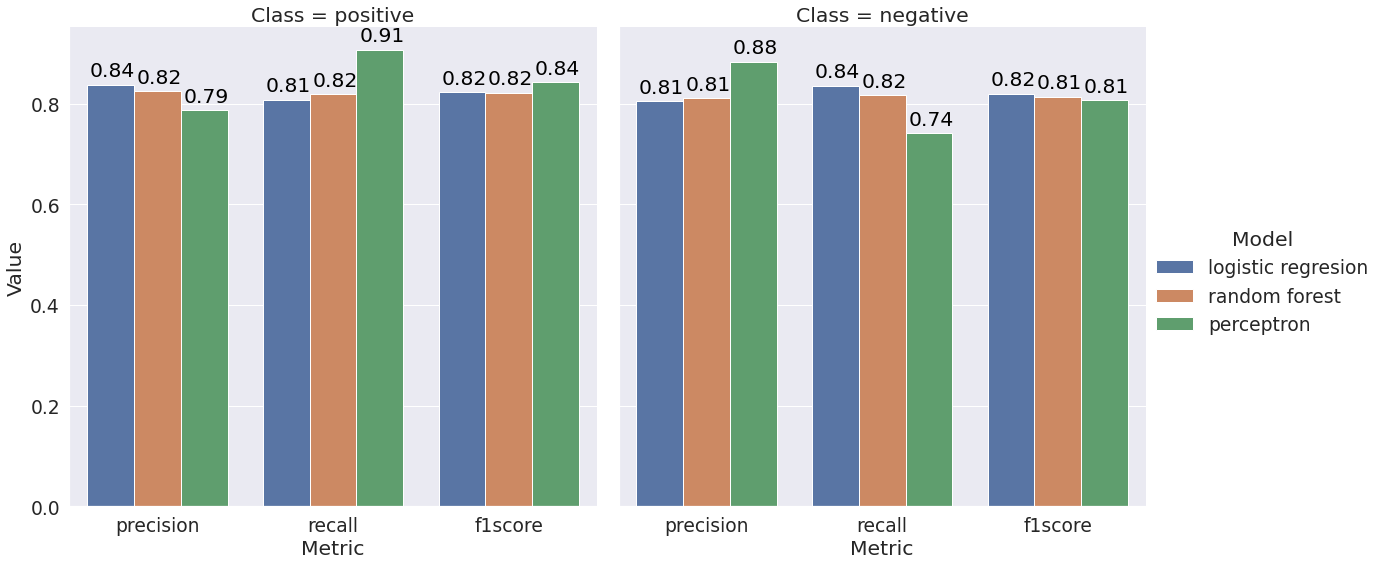

In [ ]:
model, value = ['logistic regresion', 'random forest', 'perceptron'] * 6, \
               [p_log_wv[0], p_rf_wv[0], p_per_wv[0], r_log_wv[0], r_rf_wv[0], r_per_wv[0], f1_log_wv[0], f1_rf_wv[0], f1_per_wv[0], \
               p_log_wv[1], p_rf_wv[1], p_per_wv[1], r_log_wv[1], r_rf_wv[1], r_per_wv[1], f1_log_wv[1], f1_rf_wv[1], f1_per_wv[1]]
plot_stats(value, model)

## 4. Modelo de Red Neuronal

En el apartado anterior, se probaron modelos clásicos de Machine Learning para clasificación, en este apartado se probarán modelos de Deep Learning, las Redes Neuronales.

Se realizarán una serie de modelos, variando sus parámetros para tratar de estimar el mejor modelo posible para esta tarea. Para ello, en primer lugar se probará a entrenar una red neuronal, introduciendo como datos los emebeddings entrenados anteriormente. En segundo lugar, se entrenará una red neuronal con una campa de embeddings, introduciendo el texto sin embedding. 

Esto se hará para comprobar si es mejor entrenar un modelo de word embeddings a parte para posteriormente introducirlo en la red, o si es más conveniente entrenar el embedding en la propia red.

Los parámetros que se consideran más reelevantes para probar son:
*   Capas ocultas, es interesante sabes si a mayor número de capas, los modelos funcionan mejor, o hay un número de capas óptimo para este problema.
*   Neuronas por capa, mismo caso.
*   Funciones de activación, es interesante ver la influencia que pueda tener en los resultados.
*   Optimizadores, mismo caso.
*   Funciones de coste, mismo caso.

Se estudiará las relaciones que pueden haber entre los diferentes parámetros, y si hay algun tipo de influencia entre ellos, o siempre hay alguno que funcione mejor.

Los parámetros externos al modelo, no varían entre experimentos.

In [9]:
# Número de épocas (iteraciones globales)
epochs = 40
# Tamaño de batch (lote)
batch_size = 32
#Máxima longitud del documento
max_len = 512

In [ ]:
Es necesario que el vector de etiquetas tenga un forma de tensor o matricial.

In [17]:
# Vector de etiquetas -> matriz de etiquetas
tensor_y_train = to_categorical(binary_y_train, num_classes=2)
tensor_y_test = to_categorical(binary_y_test, num_classes=2)
print("Vector de etiquetas: ", binary_y_train)
print("Matriz de etiquetas: \n", tensor_y_train)

Vector de etiquetas:  [0 1 0 ... 0 0 0]
Matriz de etiquetas: 
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


La matriz de embeddings del texto dio problemas debido a que la dimensión era (8000,), de esta forma tiene la dimensión correcta (8000 número de reviews, 100 dimensiones de embedding).

In [31]:
tensor_x_train = X_train['review_vectors'].values
tensor_x_train = np.concatenate(tensor_x_train).reshape(8000, 100)

tensor_x_test = X_test['review_vectors'].values
tensor_x_test = np.concatenate(tensor_x_test).reshape(2000, 100)

La función  `create_nn` es la encargada de construir cada modelo de redes neuronales, con los parámetros que sean escogidos. La capa de salida, necesariamente tiene que tener 2 neuronas (1 por clase) y se ha utilizado la función de activación softmax para poder discriminar mejor el máximo valor de clase obtenido para el texto.

In [25]:
def create_nn(hidden_layers, num_units, activation, optimizer, loss):
  model = Sequential()
  # Capa de entrada
  model.add(Dense(units=num_units, input_dim=tensor_x_train.shape[1], activation=activation))

  # Capas ocultas
  for _ in range(hidden_layers):
    num_units /= 2
    model.add(Dense(units=num_units, input_dim=tensor_x_train.shape[1], activation=activation))

  # Capa de salida
  model.add(Dense(2, activation='softmax'))
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

Para el caso de las redes con capa de embedding, la función  `create_embedding_nn` es la encargada de construir el modelo, variando la dimensión de los emebeddings, y el número de capas ocultas. Junto con los parámetros que hayan sido los mejores en el entrenamiento de la red sin emebeddings.

In [10]:
def create_embedding_nn(hidden_layers, emb_dim):
  model = Sequential()
  # Capa de entrada
  model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=nn_x_test.shape[1]))
  model.add(Flatten())

  # Capas ocultas
  num_units = 128
  for _ in range(hidden_layers):
    model.add(Dense(units=num_units, input_dim=nn_x_test.shape[1], activation='sigmoid'))
    num_units /= 2

  # Capa de salida
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

La función  `train_best_nn`, se utiliza de la misma forma que en el caso de los clasificadores anteriores.

In [ ]:
def train_best_nn(X, y, params, is_embedding=False):
  if is_embedding:
    base_nn = KerasClassifier(build_fn=create_embedding_nn, epochs=epochs, batch_size=batch_size, verbose=0)
  else:
    base_nn = KerasClassifier(build_fn=create_nn, epochs=epochs, batch_size=batch_size, verbose=0)
  classifier = GridSearchCV(estimator=base_nn, param_grid=params, n_jobs=1, cv=3)

  # Entrenamiento
  classifier.fit(X, y)

  means = classifier.cv_results_['mean_test_score']
  stds = classifier.cv_results_['std_test_score']
  print("Best: %f using %s" % (classifier.best_score_, classifier.best_params_))
  for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
      print("Mean test score: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
  return classifier

La función  `plot_loss_accuracy_training` grafica la pérdida y accuracy del modelo durante el entrenamiento.

In [11]:
def plot_loss_accuracy_training(history):
  print(history.history.keys())
  
  fig = plt.figure(figsize = (10, 8))
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)

  # Gráfica de la accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy', fontsize=20)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  fig = plt.figure(figsize = (10, 8))
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  
  # Gráfica de la pérdida
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss', fontsize=20)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

La función  `plot_confusion_matrix` muestra la matriz de confusión.

In [12]:
def plot_confusion_matrix(X, y, model):
  yhat = model.predict(X)
  #yhat = np.argmax(yhat)

  cm = confusion_matrix(yhat, y)
  sns.heatmap(cm, annot=True, xticklabels=["predicted 0", "predicted 1"], yticklabels=["real 0", "real 1"])

Debido a que la librería keras ya no implementa métricas de evaluación, para evaluar la precisión, recall y f1, se utilizaron las métricas de sklearn en la función `evaluate_nn_classifier`.

In [13]:
def evaluate_nn_classifier(X, y, model):
  yhat = model.predict(X)
  #yhat = np.argmax(yhat, axis=1)

  precision_ = precision_score(y, yhat)
  recall_ = recall_score(y, yhat)
  f1score_ = f1_score(y, yhat)

  print("Precision: %0.3f Recall %0.3f F1 score: %0.3f for %s" % (precision_, recall_, f1score_, "Neuronal Network"))
  return precision_, recall_, f1score_

### 4.1 Red Neuronal de capas densas

En primer lugar, se realizará una serie de pruebas con los parámetros seleccionados, para tratar de ver a priori los mejores parámetros para el modelo. Se han seleccionado los parámetros que se sabe que mejor funcionan de forma general, el número de capas y unidades es basándose en el tamaño del dataset, por que no son números demasiado altos, también para no enlentecer en exceso su entrenamiento.

Cabe destacar que este apartado ha sido complicado debido al tiempo que tarda la ejecución y el entrenamiento de tantos modelos. Inicialmente se habían seleccionado más parámetros, pero debido a las limitaciones del entorno y al tiempo, se fue reduciendo este número.

In [ ]:
params = dict(hidden_layers=[1, 2, 3], 
              num_units=[256, 128], 
              activation=['relu', 'sigmoid'], 
              optimizer=['adam', 'SGD'], 
              loss=['MSE', 'binary_crossentropy'])
neural_network = train_best_nn(tensor_x_train, tensor_y_train, params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Best: 0.840625 using {'activation': 'sigmoid', 'hidden_layers': 3, 'loss': 'binary_crossentropy', 'num_units': 128, 'optimizer': 'adam'}
Mean test score: 0.841 (+/-0.002) for params: {'activation': 'sigmoid', 'hidden_layers': 3, 'loss': 'binary_crossentropy', 'num_units': 128, 'optimizer': 'adam'}
Mean test score: 0.840 (+/-0.019) for params: {'activation': 'relu', 'hidden_layers': 2, 'loss': 'binary_crossentropy', 'num_units': 128, 'optimizer': 'adam'}
Mean test score: 0.839 (+/-0.008) for params: {'activation': 'sigmoid', 'hidden_layers': 2, 'loss': 'MSE', 'num_units': 128, 'optimizer': 'adam'}
Mean test score: 0.839 (+/-0.006) for params: {'activation': 'relu', 'hidden_layers': 2, 'loss': 'MSE', 'num_units': 256, 'optimizer': 'adam'}
Mean test score: 0.839 (+/-0.006) for params: {'activation': 'sigmoid', 'hidden_layers': 1, 'loss': 'MSE', 'num_units': 256, 'optimizer': 'adam'}
Mean test score: 0.838 (+/-0.004) for params: {'activation': 'relu', 'hidden_layers': 3, 'loss': 'MSE', 'nu

Tras probar todas las combinaciones de parámetros, se pueden sacar ciertas conclusiones en base a éstos:
*   Capas ocultas: el mejor modelo ha sido con 3 capas, parece que un mayor número de capas aumentan la accuracy del modelo, a pesar de que no parece variar demasiado, debido a que no hay mucha diferencia de 2 a 3 capas.
*   Neuronas por capa: el mejor modelo contaba con 128 neuronas la primera capa, 64 la segunda y 32 la tercera. Lo que hace ver que un mayor número de neuronas, no siempre es mejor. Tampoco parece ser demasiado significativo, sería necesario probar otros números para sacar conclusiones más contundentes.
*   Funciones de activación: el mejor caso fue con la función sigmoide. A la vista de los resultados, parece que es un parámetro dependiente de otros parámetros, como el optimizador en este caso. Si se utiliza como optimizador el Gradiente Descendente, esta función de activación funciona bastante mal, a diferencia de relu, que parece funcionar bien con este optimizador.
*   Optimizadores: el optizador adam es el claro ganador, ya que en todos los casos tiene los mejores resultados, independientemente de otros parámetros, exceptuando un caso, donde el gradiente descendente obtiene buenos resultados con la función relu, 2 capas y 256 neuronas por capa. El grandiente parece funcionar mejor en arquitecuras de varias capas, y con la función relu.
*   Funciones de coste, entropía cruzada parece funcionar ligeramente mejor que el error cuadrático medio. No parece ser un factor relevante en este modelo, ya que no hay diferencias significativas entre ambos, y tampoco parece tener relación con otros parámetros.


A continuación se entrenará el mejor modelo obtenido, para su análisis.

In [32]:
neural_network = KerasClassifier(build_fn=create_nn, hidden_layers=3, num_units=128, activation='sigmoid', optimizer='adam', loss='binary_crossentropy', 
                      epochs=epochs, batch_size=batch_size, verbose=0)
history = neural_network.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/neural_network.sav'
pickle.dump(neural_network, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://686150f9-8125-4e1c-aa9d-3c43cf37d7a6/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


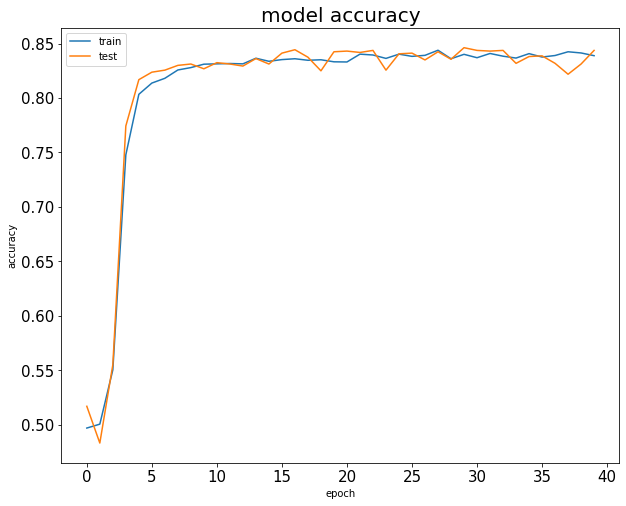

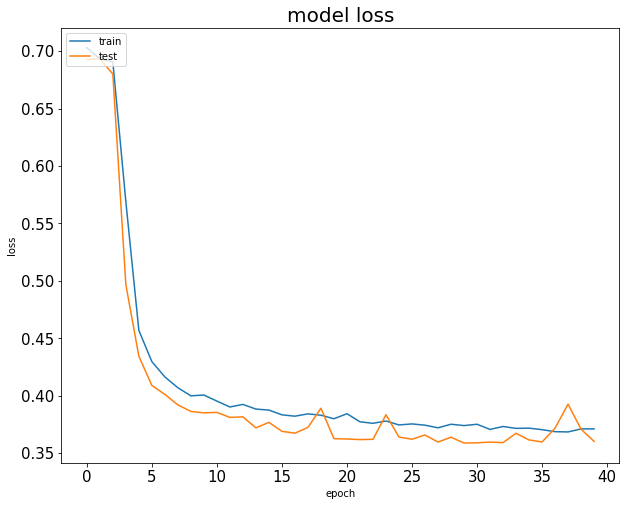

In [33]:
plot_loss_accuracy_training(history)

Tal y como muestran las gráficas, el modelo tiene una evolución bastante buena, llegando a sus valores máximos y mínimos de accuracy y pérdida.

Precision: 0.803 Recall 0.885 F1 score: 0.842 for Neuronal Network


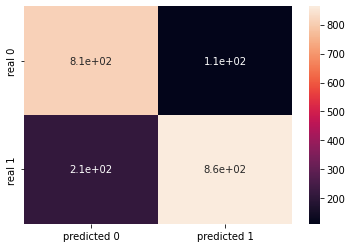

In [34]:
nn_precision, nn_recall, nn_f1score = evaluate_nn_classifier(tensor_x_test, binary_y_test, neural_network)
plot_confusion_matrix(tensor_x_test, binary_y_test, neural_network)

El modelo tiene un f1score de 84%, como el modelo Perceptrón, y se puede ver en la matriz de confusión que ha habido más problemas al etiquetar reviews positivas como negativas.

También existen técnicas para tratar con problemas como la pérdida de accuracy durante el entrenamiento. El early stopping, detiene el entrenamiento si detecta que se esta reduciendo la accuracy o aumentando el loss.

In [35]:
early_stopping_val = EarlyStopping(monitor='val_accuracy', patience=4)
history = neural_network.fit(tensor_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping_val])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


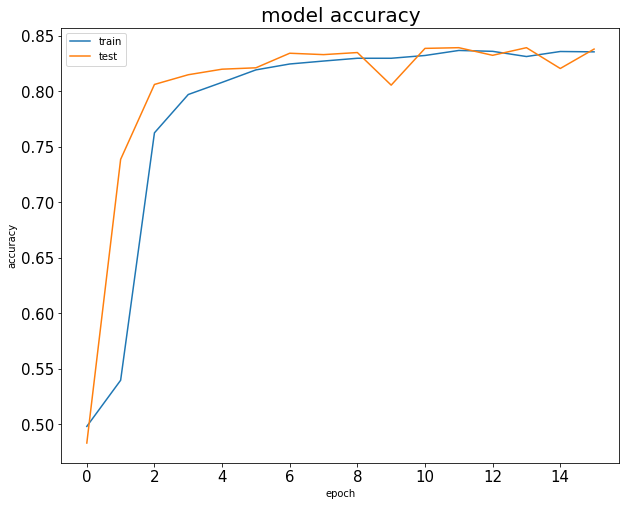

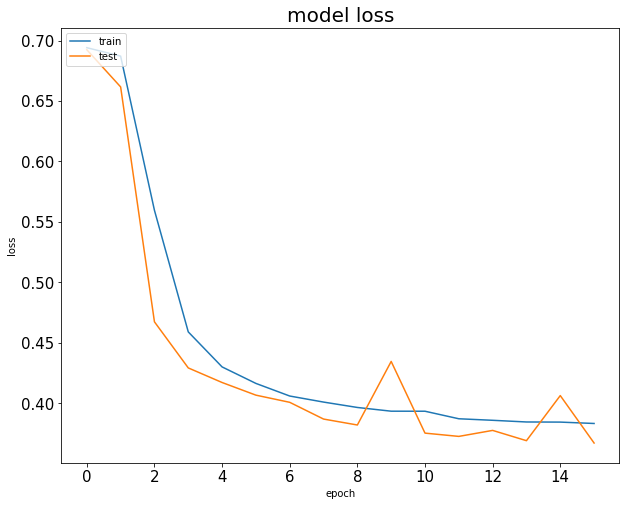

In [36]:
plot_loss_accuracy_training(history)

Precision: 0.828 Recall 0.848 F1 score: 0.838 for Neuronal Network


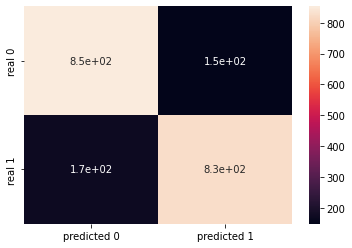

In [37]:
nn_es_precision, nn_es_recall, nn_es_f1score = evaluate_nn_classifier(tensor_x_test, binary_y_test, neural_network)
plot_confusion_matrix(tensor_x_test, binary_y_test, neural_network)

En este caso, parece no ayudar a la mejora del modelo, ya que ha bajado un poco el valor de las métricas. Esta ténica se utiliza normalemente en casos donde a curva de la accuray tenga más picos, y termine en un nivel de accuracy no máximo.

### 4.2 Red Neuronal con capa de Embedding

En este apartado se entrenará el modelo de redes neuronales con una capa de embeddings. Para ello primero es necesario procesar el texto. 

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['review_processed'])

# Se transforman a secuencias numéricas (secuencia de palabras -> secuencia de números)
sequences_train = tokenizer.texts_to_sequences(X_train['review_processed'])
sequences_test = tokenizer.texts_to_sequences(X_test['review_processed'])

# Es necesario que ambas tengan la misma longitud
nn_x_train = pad_sequences(sequences_train, maxlen=max_len)
nn_x_test = pad_sequences(sequences_test, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

print("Before: ", sequences_train[0])
print("After: ", X_train['review_processed'][0])

Before:  [23, 52, 7, 99, 746, 13705, 2177, 108, 539, 684, 66, 131, 311, 2865, 1884, 1205, 328, 504, 168, 652, 167, 1719, 3272, 843, 2866, 2359, 933, 1028, 14, 443, 35, 493, 15, 48, 22, 237, 4672, 437, 89, 182, 1765, 108, 2, 30, 280, 279, 2210, 8573, 2387, 400, 746, 4, 183, 289, 5518, 920, 1080, 467, 28, 275, 1639, 16034, 141, 287, 483, 126, 1778, 6454, 553, 300, 1011, 1158, 2, 85, 780, 2591, 3792, 1205, 328, 344, 1131, 562, 405, 3273, 3331, 1792, 2050, 3005, 5519, 1650, 16034, 3969, 654, 1016, 1720, 166, 2552, 1219, 29, 1433, 1867, 2070, 2733, 178, 328, 24, 2388, 843, 14, 573, 13, 1689, 5934, 440, 5726, 166, 1440, 921, 3883, 897, 657, 328, 1404, 271, 5321, 1966, 1844, 33, 8021, 2333, 443, 4422, 556, 2427, 106, 28, 275, 11, 101, 25, 237, 4673, 8574, 662, 241, 78, 5152, 1674, 2333, 275, 2956, 258, 93, 14, 629, 1844, 273, 1327, 29, 834, 2071, 326, 4982, 8022, 7121, 179, 1337, 250, 5, 3097, 449, 3883, 148, 3397, 496, 1690, 13, 71, 48, 16, 181, 831, 410, 648, 2, 2051, 575, 1147, 11, 63, 128

Una vez procesado el texto, se realizará un grid para trata de encontrar las dimensiones de embedding apropiadas.

Cabe destacar que este proceso de entrenamiento fue muy costoso (más de 3 horas) por lo que no ha sido factible probar con mayor número de parámetros.

In [ ]:
params = dict(hidden_layers=[2, 3], emb_dim=[50, 100, 150])
neural_network_embedding = train_best_nn(nn_x_train, tensor_y_train, params, is_embedding=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Best: 0.863625 using {'emb_dim': 50, 'hidden_layers': 2}
Mean test score: 0.864 (+/-0.007) for params: {'emb_dim': 50, 'hidden_layers': 2}
Mean test score: 0.863 (+/-0.003) for params: {'emb_dim': 100, 'hidden_layers': 2}
Mean test score: 0.860 (+/-0.003) for params: {'emb_dim': 150, 'hidden_layers': 2}
Mean test score: 0.853 (+/-0.004) for params: {'emb_dim': 50, 'hidden_layers': 3}
Mean test score: 0.843 (+/-0.014) for params: {'emb_dim': 100, 'hidden_layers': 3}
Mean test score: 0.833 (+/-0.003) for params: {'emb_dim': 150, 'hidden_layers': 3}


In [ ]:
# Guardar el modelo en disco
filename = '/content/drive/My Drive/models/neural_network_embedding.sav'
pickle.dump(neural_network_embedding, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://48bbd82c-2f98-4fa2-8369-a7a0d024e659/assets


Se entrena el modelo con los mejores parámetros.

In [ ]:
neural_network_embedding = KerasClassifier(build_fn=create_embedding_nn, hidden_layers=2, emb_dim=50, 
                                 epochs=epochs, batch_size=batch_size, verbose=0)
history = neural_network_embedding.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


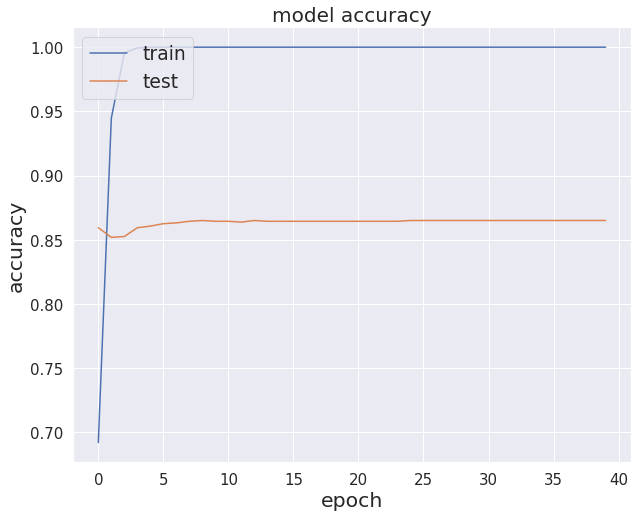

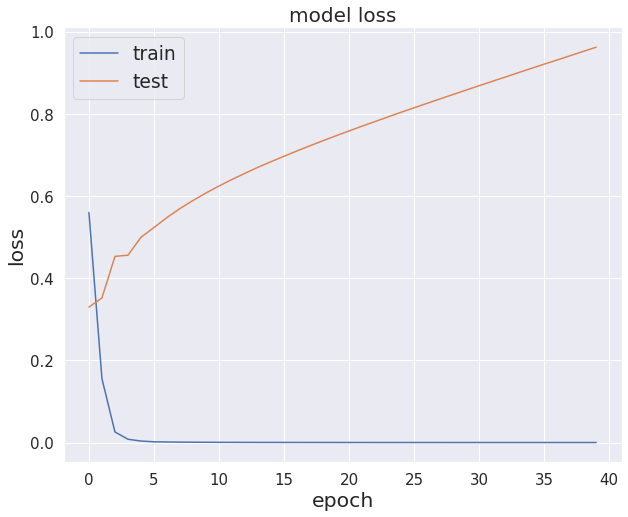

In [40]:
plot_loss_accuracy_training(history)

En este caso se puede observarse que la accuracy del modelo se mantiene constante en todo momento, sin embargo la pérdida aumenta de forma lineal, a pesar de que no empeora la accuracy.

Precision: 0.856 Recall 0.867 F1 score: 0.861 for Neuronal Network


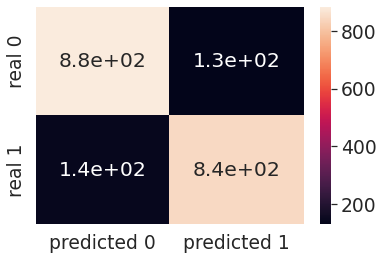

In [43]:
nn_embedding_precision, nn_embedding_recall, nn_embedding_f1score = evaluate_nn_classifier(nn_x_test, binary_y_test, neural_network_embedding)
plot_confusion_matrix(nn_x_test, binary_y_test, neural_network_embedding)

Los resultados parecen ser mejores que en modelo entrenado con embeddings, con un f1score del 86%.

### 4.3 Comparación de modelos de Redes Neuronales

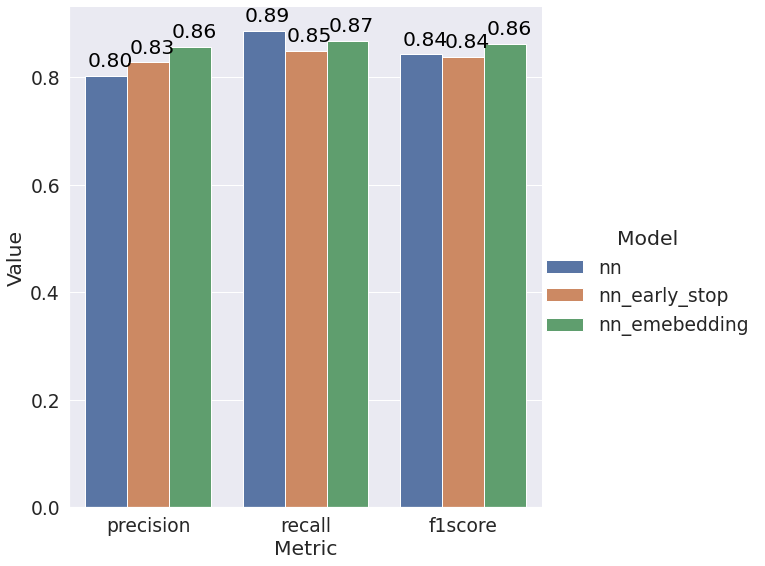

In [44]:
metric, model, value = ['precision'] * 3 + ['recall'] * 3 + ['f1score'] * 3, \
                        ['nn', 'nn_early_stop', 'nn_emebedding'] * 3, \
                        [nn_precision, nn_es_precision, nn_embedding_precision, \
                         nn_recall, nn_es_recall, nn_embedding_recall, \
                         nn_f1score, nn_es_f1score, nn_embedding_f1score]
plot_stats(value, model, class_=False)

### 5. Conclusión

Como conclusión final, se puede decir que el mejor modelo encontrado es el modelo de redes neuronales, con capa de embeddings. Es el modelo que ha obtenido mejores resultados a nivel general, y ha sido el más costoso de entrenar en tiempo.

También he visto el desarrollo de la práctica, que la representación de word emebeddings funciona mucho mejor que las otras probadas, dando resultados bastante buenos, de más de un 85% de precisión y recall.

Respecto a los parámetros de los modelos, si bien son importantes, no se han visto cambios significativos por utilizar unos parámetros u otros, salvo en casos excepcionales. Esto puede ser debido a que no se trata de modelos excesivamente complejos, ni un dataset de gran tamaño. Sería interesante indagar más en esto en próximos trabajos.

Personalmente me ha gustado bastante la práctica por que he aprendido y repasado conceptos de Machine Learning y Deep Learning, y también he practicado a nivel de código, sobre todo con las funcionalidades proporcionadas por las librerías como sklearn y keras. No me ha resultado complicado, pero si he tenido que dedicar bastante tiempo a investigar y preparar los modelos y sus hiperparámetros, junto con el tiempo de ejecución que ha llevado entrenar los modelos, lo que en ocasiones ha enlentecido el desarrollo de la práctica.
